# Photonic Circuits

Photonic circuits are critical for linear-optical quantum computing and play a crucial role in quantum communication. At the top-most level, constructing and simulating photonic circuits in ZPGenerator is very similar to [Perceval](https://perceval.quandela.net/), a framework also developed by Quandela. The main difference is that circuits in ZPGenerator cannot be analysed independent of sources and detectors. This is because ZPGenerator is a source-physics simulator as opposed to Perceval, which is a circuit-focused simulator. In ZPGenerator, as in Perceval, the object that combines sources, circuits, and detectors/post-processing is called a Processor.

In [1]:
from zpgenerator import *
import numpy as np
import matplotlib.pyplot as plt

## Building a processor

To simulate a photonic circuit, the first thing to do is create a Processor. The number of discrete processor modes needed will expand dynamically as we add components.

In [2]:
qpu = Processor()

Once we initialise a processor, we can add components to it using the add() method. We have three types of components to add: (1) sources, (2) circuits, and (3) detectors. Catalogue sources can be easily created using class methods of the Source class. These components have one or more input modes that are vacuum by default, and one or more output modes that contain pulses of light. Sources are usually placed at the beginning of a processor but ZPGenerator also handles cascaded quantum systems where the emission from one source can be used to drive another.

To demonstrate a simple example, we can simulate the Hong-Ou-Mandel (HOM) bunching effect [[C. K. Hong, Z. Y. Ou, and L. Mandel, Phys. Rev. Lett. 59, 2044 (1987)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.59.2044)]. To do this, we can add a source of perfect single photon Fock states to modes 0 and 1 of our processor.

In [3]:
qpu.add(0, Source.fock(1))
qpu.add(1, Source.fock(1))

Next, we want to add a beam splitter so that our two single photons will interfere. To do this, we can use class methods from the Circuit class to access catalogue linear-optical components.

In [4]:
qpu.add(0, Circuit.bs())

Finally, we need to place our detectors to monitor the output modes of the beam splitter. This is done using the Detector class that, like the Source and Circuit classes, has class methods to create different catalogue detector types. Since we wish to observe the HOM bunching effect, and we have only two photons, we can use photon-number resolving (PNR) detectors with a resolution of 2.

In [5]:
qpu.add(0, Detector.pnr(2))
qpu.add(1, Detector.pnr(2))

Now that we have constructed our processor, we can visualise the basic structure using the display() method. More advanced visualisation methods will be implemented in future updates.

In [6]:
qpu.display()


        _____________
|0>----|  Component  |----D~
|0>----|             |----D~
        ‾‾‾‾‾‾‾‾‾‾‾‾‾


The total two-mode processor begins with vacuum inputs, one input to each source. The component represents the combination of two Fock state sources and a beam splitter. Finally, the detectors indicate that the output modes are monitored. To break this down, we can also display all the elements composing the component by setting elements=True when displaying the processor.

In [7]:
qpu.display(elements=True)


        _______
|0>--(0|  |1>  |0)--
        ‾‾‾‾‾‾‾

        _______
|0>--(1|  |1>  |1)--
        ‾‾‾‾‾‾‾

        ______
   --(0|  BS  |0)--
   --(1|      |1)--
        ‾‾‾‾‾‾

        ________
   --(0|  PNRD  |0)--D~
        ‾‾‾‾‾‾‾‾

        ________
   --(1|  PNRD  |1)--D~
        ‾‾‾‾‾‾‾‾


This function illustrates each element, or subcomponent, with its name and also the arrangement of ports and their labels connecting the different elements together. Note that sources and detectors are just special types of components where all inputs are vacuum, or all outputs are monitored, respectively.

## Simulating correlations

Now that we have built the processor, the next step is to simulate it. To do this, we can ask for the probabilities using the probs() method of the Processor class.

In [8]:
probabilities = qpu.probs()

Detection probabilities are returned as a CorrelationDistribution object that takes tuples of positive integers as keys. To check that we have HOM bunching, we must ensure that the coincidence count outcome corresponding to the tuple (1, 1) has a zero probability of occurring.

In [9]:
probabilities[1, 1] == 0

True

As expected, our processor never produces the (1, 1) detection pattern due to the HOM bunching effect. We can also diplay the distribution to see all non-negligible probabilities.

In [10]:
probabilities.display()

Pattern | Probability
2 0     | 0.50000
0 2     | 0.50000



Because we are using perfect source of single-photon Fock states and we have not included any losses, we never observe single-photon outcomes or vacuum outcomes. The photon-number patterns registered by each detector are ordered, by default, according to their spatial mode. That is, the pattern (2, 0) indicates that 'PNRD' monitoring mode 0 detected 2 photons while 'PNRD' monitoring mode 1 detected 0 photons.

It's important to note that, unlike Perceval, detection probabilities _do not_ always represent state probabilities. Hence, ZPGenerator uses the notation '2 0' and not '|2,0>' to represent outcomes. In ZPGenerator, the detection probabilities are integrated over time, and thus can only be considered Fock state probabilities if the state of light is actually in a pure Fock state. Since we are using a perfect source of Fock states in this first example, we can equate measuring '2 0' with measuring '|2,0>' but this is not always true.

<h5 ><font color='black'>A note on detector resolution </font></h5>

A very important point about using PNR detectors in ZPGenerator is that they must be given a resolution as large or larger than the largest photon number that it could measure with a non-negligible probability, or else the outcome probabilities will be modified by aliasing. To demonstrate this effect, consider what happens when simulating a 3-photon Fock states using a PNR detector with a resolution of 2.

In [11]:
qpu = Processor()
qpu.add(0, Source.fock(3))
qpu.add(0, Detector.pnr(2))
qpu.probs().display()

Pattern | Probability
0       | 1.00000



Notice that we expected 3 photons with a probability of 1, but measured 0 photons instead. This is because any detection probability that exceeds the resolution 'wraps around' and adds to the distribution, i.e., modulo the resolution. This behaviour is fully expected based on the theory of how the backend works, and can be a useful feature in some cases. However, it can cause confusion if not taken into account when simulating a processor.

## Threshold detection

An interesting feature of ZPGenerator is the ability to simulate threshold detectors without first simulating all the number-resolved outcomes. Threshold detectors detect either zero photons (no click) or at least one photon (click). This type of detector is commonly used to model avalanche photodiode (APD) detectors and non-resolving superconducting nanowire single-photon detectors (SNSPD). Unlike photon-number resolved outcomes, ZPGenerator will not return aliased distributions if the number of photons incident exceeds the threshold detector resolution of 1. This is because threshold detection produces a finite set of outcomes that requires no truncation.

Let's quickly rewrite the same HOM processor, but now using threshold detectors. In this case, we will use the shorthand // notation to add components and specify lists of integers to add a component to multiple modes at the same time.

In [12]:
qpu = Processor() // ([0, 1], Source.fock(1)) // Circuit.bs() // ([0, 1], Detector.threshold())
qpu.probs().display()

Pattern | Probability
0 1     | 0.50000
1 0     | 0.50000



When using threshold detectors, a 0 represents the same outcome as it does for PNR detectors. However, a 1 now indicates at least one photon was detected. Comparing this with our number-resolved simulation of the HOM effect, we can see that threshold detectors register 2-photon outcomes as a single click. In many cases, threshold detection is sufficient to understand how the source and circuit interact, such as this HOM interference experiment where we only want to identify the absence of coincidence counts. This is why, in practice, HOM interference experiments used to characterise single-photon sources are performed using threshold detectors.

In general, ZPGenerator also allows us to mix and match different sources and detectors, or even leave many inputs or outputs empty. As in permanent-based simulators, like Perceval, the time needed to simulate an experiment using ZPGenerator depends on the Hilbert space size of the input states or sources, and the number of outcomes for the outputs being monitored, but not the size of the circuit.

In [13]:
qpu = Processor()
qpu.add(0, Source.fock(1))
qpu.add(7, Source.fock(3))
qpu.add(15, Source.fock(2))
qpu.add(0, Circuit.haar_random(24))
qpu.add(0, Detector.threshold(bin_name='TD 1'))
qpu.add(12, Detector.threshold(bin_name='TD 2'))
qpu.add(8, Detector.pnr(6, bin_name='PNRD'))
qpu.probs().display()

Pattern | Probability
0 0 0   | 0.46479
0 1 0   | 0.09099
0 2 0   | 0.01460
0 3 0   | 0.00178
0 4 0   | 0.00013
0 0 1   | 0.12664
0 1 1   | 0.02085
0 2 1   | 0.00320
0 3 1   | 0.00030
0 4 1   | 0.00002
1 0 0   | 0.19182
1 1 0   | 0.04545
1 2 0   | 0.00668
1 3 0   | 0.00066
1 4 0   | 0.00004
1 0 1   | 0.02436
1 1 1   | 0.00663
1 2 1   | 0.00100
1 3 1   | 0.00007



In more complicated experiments such as the example above, it is useful to assign detectors to a unique bin using the 'bin_name' keyword, as done above. Then, we can always look to see what the order of the outcomes in the pattern represent by checking the bin_labels property of the processor.

In [14]:
qpu.bin_labels

['TD 1', 'PNRD', 'TD 2']

The bin_name keyword also allows detectors to serve more complex functionalities than just monitoring a single mode for the entirety of the experiment. We may have multiple detectors monitoring the same mode but at different times, or one detector monitoring multiple modes simultaneously and binning the results together.

## Binned detectors

Sometimes we do not need to know the individual outcomes for different detectors, but instead only need to know their summed results. For example, this technique of binning detectors together can be used to validate Boson Sampling results [[B. Seron, et al., arXiv: 2212.09643 (2022)](https://arxiv.org/abs/2212.09643)]. To bin the results of two detectors in ZPGenerator, we must assign them the same bin name and also ensure that they are the same detector type and have the same resolution. Let's take a look at 4 photons passing through a 24-mode Haar random circuit, but divide the 24 outputs into two groups. Note that, without binning, there are 17750 possible outcomes. But, by binning into two groups, we have just 5 possible outcomes.

In [15]:
qpu = Processor()
qpu.add([0, 1, 2, 3], Source.fock(1))
qpu.add(0, Circuit.haar_random(24))
qpu.add(list(range(0, 12)), Detector.pnr(4, bin_name='bin 0'))
qpu.add(list(range(12, 24)), Detector.pnr(4, bin_name='bin 1'))
qpu.probs().display()

Pattern | Probability
4 0     | 0.08011
3 1     | 0.25627
2 2     | 0.35144
1 3     | 0.24149
0 4     | 0.07069



At this point, it is worth mentioning that ZPGenerator is generally a lot slower than Perceval for problems that both frameworks can tackle. This is because ZPGenerator is designed to solve general noisy time-dynamic problems, which can be overkill when simulating ideal photons as in the above scenarios. However, the backend is extremely flexible and can provide solutions to a wide range of realistic experimental setups that cannot be simulated using Perceval.

## Imperfect sources

Without going too deep into source physics, we can also use ZPGenerator to simulate a wide variety of realistic source types. The easiest way to accomplish this is to use the different catalogue sources available from the Source class. To demonstrate, let's revisit the Hong-Ou-Mandel scenario but using a more realistic source type that includes source inefficiency, multi-photon emission, and non-ideal indistinguishability. To obtain a source that produces a photon with known efficiency, integrated intensity correlation ($g^{(2)}), and amount of indistinguishability, we can use the perceval() source model.

This source type is based on a simplified noise model of a near-ideal single photon produced by the fast excitation of a two-level emitter. Thus, we get at most two photons from each source, and the additional photon of the multiphoton component is completely distinguishable from the single photon component as demonstrated in [[H. Ollivier et al., Phys. Rev. Lett. 126, 063602 (2021)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.126.063602)]. It is named as such because it is the same model that is used in the Source class in Perceval.

In [16]:
source = Source.perceval(emission_probability=0.85,
                         multiphoton_component=0.05,
                         indistinguishability=0.9)
qpu = Processor()
qpu.add([0, 1], source)
qpu.add(0, Circuit.bs())
qpu.add([0, 1], Detector.pnr(4))
qpu.probs().display()

Pattern | Probability
0 0     | 0.02250
1 0     | 0.12467
2 0     | 0.32826
3 0     | 0.00745
4 0     | 0.00009
0 1     | 0.12467
1 1     | 0.03992
2 1     | 0.00823
0 2     | 0.32826
1 2     | 0.00823
2 2     | 0.00017
0 3     | 0.00745
0 4     | 0.00009



By going one step deeper into the physics, we can also modify the physical parameters of catalogue components to create imperfections.

## Parameters

ZPGenerator is built to handle components that may be controlled by many different parameters. This is particularly important once we start building new components and time-dynamic control pulses in a composable way. In this section, we will take a look at the basic methods we can use to modify parameters controlling the simulation model.

All components come with a set of default parameters that can be overwritten when simulating the processor. To see what parameters we can modify, let's once again build a basic HOM setup and look at the list of parameters automatically included by the included catalogue components. This time, we will define our components first, and then add them to the processor using the shorthand // symbol.

In [17]:
source = Source.fock(1)
circuit = Circuit.bs()
detector = Detector.pnr(2)

qpu = Processor() // ([0, 1], source) // (0, circuit) // ([0, 1], detector)

print(qpu.parameters)

['angle', 'decay', 'delay', 'dephasing', 'efficiency', 'resonance']


By printing the parameters property of the processor, we can see there are many parameters and perhaps their functionalities are not clear because we don't know which components they belong to. One option is to check the parameters of each component individually.

In [18]:
print(source.parameters)
print(circuit.parameters)
print(detector.parameters)

['decay', 'delay', 'dephasing', 'efficiency', 'resonance']
['angle']
['efficiency']


We can see that each component has its own list of parameters, and together they make all the parameters of the processor. However, we must be _very careful_ because both the source and detector component have the same parameter "efficiency". So, if we change the efficiency parameter, it will apply twice---once at emission and once at detection. To avoid parameter clashes like this, it is important to always give each component a unique name so that we can control their parameters individually.

In [19]:
source.name = 'source'
circuit.name = 'beamsplitter'
detector.name = 'detector'
print(qpu.parameters)

['beamsplitter/angle', 'detector/efficiency', 'source/decay', 'source/delay', 'source/dephasing', 'source/efficiency', 'source/resonance']


Now we can easily see which parameters belong to which component. More importantly, we can specify which parameter to modify. Before doing this, let's take a look at what the default parameters are.

In [20]:
qpu.default_parameters

{'source/resonance': 0.0,
 'source/dephasing': 0.0,
 'source/delay': 0.0,
 'source/decay': 1.0,
 'source/efficiency': 1,
 'beamsplitter/angle': 0.7853981633974483,
 'detector/efficiency': 1}

Here, we can see that our source is emitting light that is resonant (resonance = 0) with respect to the global reference. There is also no dephasing impacting the amplitude coherence of the light (dephasing = 0), the 'delay' parameter being 0 indicates that the emission occurs at time t=0, and the decay rate of the source (governing the emission timescale) is set to 1. The source also has an efficiency parameter, which can represent a collection efficiency, which is set to 1 by default. The beamsplitter is has a 50:50 ratio by default, corresponding to an angle of $\pi/4$. Finally, the detector has an efficiency of 1.

The majority of the time, we don't care to modify all these default parameters. But, perhaps we want to modify only one or two of them. To do this, we simply specify the parameter to modify when simulating the processor. Let's increase the source dephasing and see how it impacts the HOM bunching effect.

In [21]:
qpu.probs(parameters={'source/dephasing': 0.1}).display()

Pattern | Probability
2 0     | 0.47727
1 1     | 0.04545
0 2     | 0.47727



By specifying a new value for 'source/dephasing' we will add some pure dephasing to the fock state, which leads to some amount of distinguishability, preventing perfect HOM bunching, and thus we observe '1 1' coincidence counts.

The way parameters work in ZPGenerator allow us to also specify the common part of one or more parameters to modify all parameters with that common name. For example, we have two 'efficiency' parameters: 'source/efficiency' and 'detector/efficiency'. We can modify them individually using their full name, or we can modify them both at the same time using their common name.

In [22]:
qpu.probs(parameters={'source/efficiency': 0.5}).display()
qpu.probs(parameters={'efficiency': 0.5}).display()
qpu.probs(parameters={'efficiency': 0.5}) == qpu.probs(parameters={'source/efficiency': 0.5, 'detector/efficiency': 0.5})

Pattern | Probability
0 0     | 0.25000
1 0     | 0.25000
2 0     | 0.12500
0 1     | 0.25000
0 2     | 0.12500

Pattern | Probability
0 0     | 0.56250
1 0     | 0.18750
2 0     | 0.03125
0 1     | 0.18750
0 2     | 0.03125



True

As you can see, modifying 'source/efficiency' to 0.5 will reduce the emission efficiency of the sources to 50%. However, by modifying 'efficiency' to 0.5, we will change both 'source/efficiency' and 'detector/efficiency', resulting in more losses.

If two components have parameters with the same name but with different default values, no parameter clashes will occur. Thus, another way to avoid parameter clashes is to assign different default parameters to components when creating them or to update their default parameters before simulating the processor.

In the next section, we will use this approach to take a look at modifying the 'delay' parameter, but for each source independently.

## Time dynamics

Since ZPGenerator is based on a time-dynamic backend, manipulating relative temporal properties of sources is natural. For example, by shifting the relative delay of the photons as above, we can see that the photons are partially distinguishable allowing for '1 1' coincidences similar to the case when we added dephasing.

In [23]:
beamsplitter = Circuit.bs()
detector = Detector.pnr(2)

qpu = Processor()
qpu.add(0, Source.fock(1, parameters={'delay': 0}))
qpu.add(0, Source.fock(1, parameters={'delay': 0.1}))
qpu = qpu // beamsplitter // ([0, 1], detector)

qpu.probs().display()

Pattern | Probability
2 0     | 0.47621
1 1     | 0.04758
0 2     | 0.47621



Setting parameters in this way is convenient because we do not need to name each component, but we have to be careful to note that it only impacts the default values. If we try to modify 'delay', it will modify both the parameter for both sources, which eliminates the relative delay and restores HOM bunching.

To get a better idea of what is happening in the above simulation, we can sweep the delay of one photon across the other and see how the anti-bunching probability is modified. To make things more interesting, let's also compare it to delaying a wavepacket when we have additional pure dephasing.

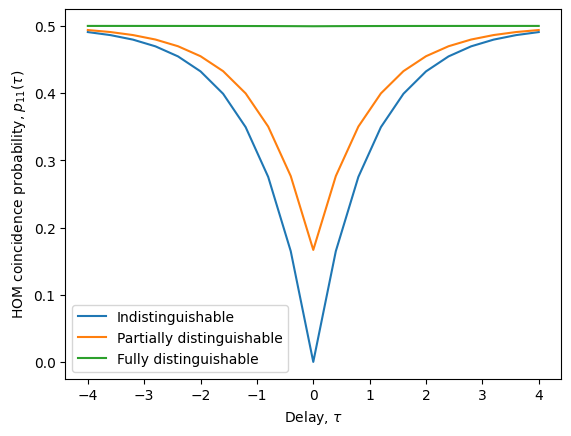

In [24]:
qpu = Processor()
qpu.add(0, Source.fock(1, name='source 0'))
qpu.add(1, Source.fock(1, name='source 1'))
qpu.add(0, Circuit.bs())
qpu.add([0, 1], Detector.threshold())

def pr11(delay: float, dephasing: float):  # make a function to simulate the coincidence probability
    return qpu.probs(parameters={'source 1/delay': delay, 'dephasing': dephasing})[1, 1]

# Let's generate data for a set of delays and for three different regimes of dephasing
delays = np.linspace(-4, 4, 21)
coinc_indi = [pr11(tau, 0.0) for tau in delays]  # no dephasing (indistinguishable)
coinc_deph = [pr11(tau, 0.5) for tau in delays]  # some dephasing (partially distinguishable)
coinc_dist = [pr11(tau, 10**3) for tau in delays]  # lots of dephasing --> distinguishable

# Now let's plot them to compare!
plt.plot(delays, coinc_indi, label = 'Indistinguishable')
plt.plot(delays, coinc_deph, label = 'Partially distinguishable')
plt.plot(delays, coinc_dist, label = 'Fully distinguishable')
plt.xlabel('Delay, $\\tau$')
plt.ylabel('HOM coincidence probability, $p_{11}(\\tau)$')
plt.legend()
plt.show()

When there is no dephasing, we see a clear dip in the coincience probability $p_{11}$ down to zero when the delay $\tau$ is zero. When we add some dephasing, there is still a dip, but it does not go all the way to $p_{11}=0$. In the case where dephasing is very large, we can see that there is no dip at all, corresponding to completely distinguishable photons regardless of how they overlap in time.

## Losses

ZPGenerator also naturally takes into account losses, both uniform and non-uniform, at no additional computational cost. The easiest way to control losses is to add loss components in the circuit. As an example, let's look at a single photon passing through a Mach-Zehnder interferometer with unbalanced losses.

In [25]:
qpu = Processor() // Source.fock(1) // Circuit.bs() // Circuit.loss(name='arm 0') // Circuit.bs() // ([0, 1], Detector.threshold())
qpu.probs().display()

Pattern | Probability
0 1     | 1.00000



By default, a circuit loss component will have perfect transmission. In that case, we can see above that the perfect single-photon interference that results in only '0 1' outcomes at the output of the interferometer. However, if we add a small amount of losses, we can disturb the interference. Not only do we reduce '0 1' outcomes, but we can actually _increase_ '1 0' outcomes!

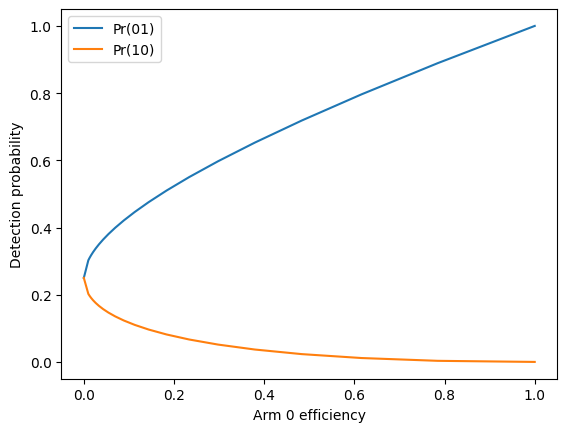

In [26]:
probs01 = []
probs10 = []
efficiencies = [0] + [10**eta for eta in np.linspace(-2, 0, 20)]
for eta in efficiencies:
    prbs = qpu.probs(parameters={'arm 0/efficiency': eta})
    probs01.append(prbs[0, 1])
    probs10.append(prbs[1, 0])

plt.plot(efficiencies, probs01, label = 'Pr(01)')
plt.plot(efficiencies, probs10, label = 'Pr(10)')
plt.xlabel('Arm 0 efficiency')
plt.ylabel('Detection probability')
plt.legend()
plt.show()

This interesting phenomenon is behind a paradox called the 'interaction free measurement'. Notice that, by detecting the outcome '1 0', we can infer the presence of an absorbing object in one arm of the interferometer. However, since we only used a single photon, and we detected that photon, the photon never interacted with the absorbing object! This interaction free measurement occurs with 25\% probability in the limit of a perfectly absorbing object.